In [3]:
import geopandas
import shapely
from shapely import Point, LineString, Polygon, MultiPolygon

In [18]:
a = [Point(1,1), Point(5,8), Point(7,20), Point(2,6), Point(1,1)]
a = Polygon(a)
print(a)

POLYGON ((1 1, 5 8, 7 20, 2 6, 1 1))


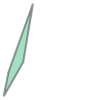

In [19]:
a

In [36]:
xx,yy = a.exterior.coords.xy
coords = a.exterior.coords.xy

In [41]:
x_coords = xx.tolist()
y_coords = yy.tolist()

In [42]:
x_coords 

[1.0, 5.0, 7.0, 2.0, 1.0]

In [43]:
y_coords

[1.0, 8.0, 20.0, 6.0, 1.0]

In [55]:
for i in range(0, len(x_coords)-1):
    coords_start = (x_coords[i], y_coords[i])
    coords_end = (x_coords[-1], y_coords[-1])
    
    if coords_start == coords_end:
        print("It ends with same coordinates")

It ends with same coordinates


In [60]:
def great_circle_dist(phi1,phi2,lam1,lam2):
    phi1 = math.radians(phi1) 
    phi2 = math.radians(phi2)
    lam1 = math.radians(lam1)
    lam2 = math.radians(lam2)
    dl = abs(lam1-lam2) 
    d = math.acos((math.sin(phi1)*math.sin(phi2))+(math.cos(phi1)*math.cos(phi2)*math.cos(dl)))
    spheric_dist = round(d*6300)
    return spheric_dist

In [61]:
import math

for i in range(0, len(x_coords)-1):
    phi1 = x_coords[i] 
    phi2 = x_coords[i+1]
    lam1 = y_coords[i]
    lam2 = y_coords[i+1]
    
    spheric_dist = great_circle_dist(phi1,phi2,lam1,lam2)
    
    print(f"Distance between Point{i} and Point{i+1}: {spheric_dist} Kms")

Distance between Point0 and Point1: 885 Kms
Distance between Point1 and Point2: 1330 Kms
Distance between Point2 and Point3: 1630 Kms
Distance between Point3 and Point4: 560 Kms


In [62]:
import math

def calculate_angle(x1,x2,y1,y2):
    x1 = math.radians(x1) 
    x2 = math.radians(x2)
    y1 = math.radians(y1)
    y2 = math.radians(y2)
    angle = math.atan2(y2 - y1, x2 - x1) * 180 / math.pi
    return angle

In [63]:
for i in range(0, len(x_coords)-1):
    x1 = x_coords[i] 
    x2 = x_coords[i+1]
    y1 = y_coords[i]
    y2 = y_coords[i+1]
    
    angle = calculate_angle(x1,x2,y1,y2)
    
    print(f"Distance between Point{i} and Point{i+1}: {angle} degrees")

Distance between Point0 and Point1: 60.25511870305779 degrees
Distance between Point1 and Point2: 80.53767779197437 degrees
Distance between Point2 and Point3: -109.65382405805333 degrees
Distance between Point3 and Point4: -101.30993247402021 degrees
